In [1]:
import torch

import torchvision
import os
from pathlib import Path
import time

# Import libraries
import os
import time
import random
import numpy as np
from numpy import argmax
import pandas as pd
import json
from collections import OrderedDict, namedtuple
from itertools import product
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

In [3]:
if IN_COLAB:

    from google.colab import drive
    drive.mount('/drive', force_remount=True)
    datadir = '/drive/My Drive/Colab Notebooks/Datasets/'
    optim_dir = datadir + '/optim_dir/'
    results_folder = datadir+'/results/'
    Path(results_folder).mkdir(parents=True, exist_ok=True)
    Path(optim_dir).mkdir(parents=True, exist_ok=True)
else:
  results_folder = 'results'
  optim_dir = 'optim_dir'
  Path("results").mkdir(parents=True, exist_ok=True)
  Path(optim_dir).mkdir(parents=True, exist_ok=True)


# from opfunu.cec_basic.cec2014_nobias import *
# from mealpy.swarm_based.PSO import BasePSO

Mounted at /drive


In [4]:
import sys
if IN_COLAB:
  
  scripts_dir = '/drive/My Drive/Colab Notebooks/scripts/'
  sys.path.insert(1, scripts_dir)
# from opfunu.cec_basic.cec2014_nobias import *
# from mealpy.swarm_based.PSO import BasePSO

# insert at 1, 0 is the script path (or '' in REPL)
else:
    sys.path.insert(1, 'scripts')
from geneticalgorithm import geneticalgorithm as ga

In [5]:
# Enable GPU processing
if IN_COLAB:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(f'Device type: {device}')

Device type: cuda


In [6]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)


In [7]:
# Set random seed
seed = 777
torch.manual_seed(seed)
model = None

In [8]:
import random
def seeding(SEED):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    os.environ['TF_CUDNN_DETERMINISTIC'] = str(SEED)
    # tf.random.set_seed(SEED)
    print('seeding done!!!')
seeding(seed)

seeding done!!!


In [9]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(datadir, train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(datadir, train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

data = {
    'train': 
    torchvision.datasets.MNIST(datadir, train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
    'val': 
    torchvision.datasets.MNIST(datadir, train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
}

In [10]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [11]:
example_data.shape

torch.Size([1000, 1, 28, 28])

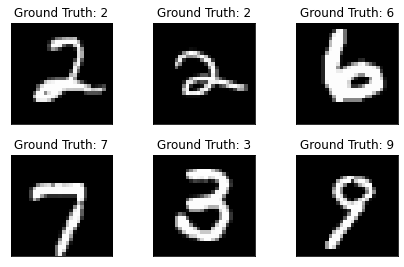

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])


In [13]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(1600, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        # exit()
        x = self.dropout2(x)
        
        x = self.fc1(x)
        output = F.log_softmax(x, dim=1)
        return output

In [15]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

# If we were using a GPU for training, we should have also sent 
# the network parameters to the GPU using e.g. network.cuda(). 
# It is important to transfer the network's parameters to the appropriate 
# device before passing them to the optimizer, otherwise the optimizer will 
# not be able to keep track of them in the right way.

In [16]:
print(network)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1600, out_features=10, bias=True)
)


In [17]:
# Define a class to build run execution sets based on a dictionary of hyperparameters
class RunBuilder():
    @staticmethod
    def get_runs(params):
        Run = namedtuple('Run', params.keys())
        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))
        return runs

In [18]:
# Create a class to manage the training / hyperparameter runs
class RunManager():
  def __init__(self):
    self.epoch_count = 0
    self.train_loss = 0
    self.train_num_correct = 0
    self.val_loss = 0
    self.val_num_correct = 0

    self.run_params = None
    self.run_count = 0
    self.run_data = []

    self.model = None
    self.train_loader = None
    self.val_loader = None
    self.tb = None
    
    #---
    self.results = None

  def begin_run(self, run, model, train_loader, val_loader):
    self.run_params = run
    self.run_count += 1
    self.model = model.to(device)
    self.train_loader = train_loader
    self.val_loader = val_loader
    self.tb = SummaryWriter(log_dir='/runs', max_queue=20, comment=f'-{run}')
    images, labels = next(iter(self.train_loader))
    images, labels = images.to(device), labels.to(device)
    self.tb.add_graph(self.model, images)
    

  def end_run(self):
    self.tb.close()
    self.epoch_count = 0

  def begin_epoch(self):
    self.epoch_count += 1
    self.train_loss = 0
    self.train_num_correct = 0
    self.val_loss = 0
    self.val_num_correct = 0

  def end_epoch(self):
    train_loss = self.train_loss / len(self.train_loader.dataset)
    train_accuracy = self.train_num_correct / len(self.train_loader.dataset)
    val_loss = self.val_loss / len(self.val_loader.dataset)
    val_accuracy = self.val_num_correct / len(self.val_loader.dataset)

    self.tb.add_scalar('Train Loss', train_loss, self.epoch_count)
    self.tb.add_scalar('Train Accuracy', train_accuracy, self.epoch_count)
    self.tb.add_scalar('Val Loss', val_loss, self.epoch_count)
    self.tb.add_scalar('Val Accuracy', val_accuracy, self.epoch_count)

    for name, param in self.model.named_parameters():
      self.tb.add_histogram(name, param, self.epoch_count)
      #self.tb.add_histogram(f'{name}.grad', param.grad, self.epoch_count)

    print(f'Epoch: {self.epoch_count}, Train Loss: {train_loss:.3f}, Train Acc: {train_accuracy:.4f}')
    print(f'Epoch: {self.epoch_count}, Valid Loss: {val_loss:.3f}, Valid Acc: {val_accuracy:.4f}')
    
    results = OrderedDict()
    results['run'] = self.run_count
    results['epoch'] = self.epoch_count
    results['train loss'] = train_loss
    results['train acc'] = train_accuracy
    results['valid loss'] = val_loss
    results['valid acc'] = val_accuracy
    
    # ---
    self.results = results

    for k, v in self.run_params.items():
      results[k] = v

    self.run_data.append(results)

  def track_loss(self, loss, mode):
    if mode == 'train':
      self.train_loss += loss.item() * self.train_loader.batch_size
    elif mode == 'val':
      self.val_loss += loss.item() * self.val_loader.batch_size

  def track_num_correct(self, preds, labels, mode):
    if mode == 'train':
      self.train_num_correct += preds.argmax(dim=1).eq(labels).sum().item()
    elif mode == 'val':
      self.val_num_correct += preds.argmax(dim=1).eq(labels).sum().item()

  def save_output(self, filename):
    if filename:
      filename = filename
      pd.DataFrame.from_dict(self.run_data, orient='columns').to_csv(f'{filename}.csv')
      
      # with open(f'{filename}.json', 'w', encoding='utf-8') as f:
      #   json.dump(self.run_data, f, ensure_ascii=False, indent=4)

      # print('Results saved to disk')

    return pd.DataFrame.from_dict(self.run_data, orient='columns')


In [19]:
# Define training loop execution
def execution_loop(m, model, args): # args is given by the optimizer
    agent = {}
    agents = []
    power = args[0].astype(int)
    num = args[0] - power 
    tmp = num * 10.0**-power
    agent['lr'] = round(tmp, 6)
    agent['batch_size'] = int(args[1])
    agents.append(agent)
#     m = RunManager()
    for run in agents: # this should be one. a particle in pso

        count = 0
        prev_valid_accs = []

        # instantiate the neural network model
        #     model = CNN_model(run.hidden_units, run.dropout, run.num_classes) 
        optimizer = Adam(model.parameters(), lr=run['lr'])

        # Define the data loaders
        dataloaders = {
            'train': DataLoader(data['train'], batch_size=run['batch_size'], shuffle=True, num_workers=1),
            'val': DataLoader(data['val'], batch_size=run['batch_size'], shuffle=False, num_workers=1)
        }

        train_loader = dataloaders['train']
        val_loader = dataloaders['val']  

        print(f'Run Params: {run}')

        m.begin_run(run, model, train_loader, val_loader)
        for epoch in range(params['n_epochs'][0]):
            
            if epoch > 2:
                
                if prev_valid_acc < 0.7:
                    break
            if epoch > 15:
                
                if max(prev_valid_accs) < 0.97:
                    break
            if epoch > 19:
                
                if max(prev_valid_accs) < 0.98:
                    break
            if epoch > 8 and prev_valid_accs[-1] <= prev_valid_accs[-2]:
                for i in range(2, len(prev_valid_accs)):
                    if prev_valid_accs[-1] <= prev_valid_accs[-i]:
                        count += 1
                        if count > 3:
                            optimizer.param_groups[0]['lr'] = run['lr'] * 0.1
                            count = 0
                            break
            m.begin_epoch()
            for batch in train_loader:
                with torch.set_grad_enabled(True):
                    # get inputs/targets and move tensors to GPU
                    images, labels = batch[0].to(device), batch[1].to(device)
                    # clear previous gradients
                    optimizer.zero_grad()
                    # make prediction
                    yhat = model(images)
                    # calculate the loss
                    loss = F.nll_loss(yhat, labels)
                    # perform back prop
                    loss.backward()
                    # update model weights
                    optimizer.step()

                    m.track_loss(loss, 'train')
                    m.track_num_correct(yhat, labels, 'train')

            else:
                with torch.no_grad():
                    for batch in val_loader:
                        images, labels = batch[0].to(device), batch[1].to(device)
                        output = model(images)
                        loss = F.nll_loss(output, labels)

                        m.track_loss(loss, 'val')
                        m.track_num_correct(output, labels, 'val')

            m.end_epoch()
            prev_valid_acc = m.results['valid acc']
            prev_valid_accs.append(prev_valid_acc)
    m.end_run()
    return model, max(prev_valid_accs)

In [20]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [21]:
# Define training run hyperparameters
params = {
    'hidden_units' : [256],
    'dropout' : [0.5],
    'num_classes' : [10],
    'lr' : [0, 1],
    'batch_size' : [20, 2000],
    'n_epochs' : [30]
}

# params = OrderedDict(
#     lr = [0, 1],
#     batch_size = [20 2000],
#     n_epochs = [3]
# )

In [22]:
m = RunManager()
timestr = time.strftime("%Y%m%d-%H%M%S")
filename = f'Run_Results-MNIST-GA-test-idea-lr-FR--{timestr}'
# filename = 'Run_Results-MNIST-BBO-test-idea-lr---20210512-083324-cont' # this is for trying to continue from last optim save


In [23]:
def run_train_model(agent):
    network = Net()
    model, valid_acc = execution_loop(m, network, agent)
    m.save_output(f'{results_folder}/{filename}')
    print("valid acc: ", valid_acc)
    return valid_acc * -1

In [24]:
# optim_data = None
# import pickle
# tmp = 'ga_data-20210512-132343-cont.data'
# with open(f"{optim_dir}/{tmp}", 'rb') as f:
#     optim_data = pickle.load(f)

# print(optim_data)

Run Params: {'lr': 0.610655, 'batch_size': 618}


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Streaming output truncated to the last 5000 lines.
Epoch: 4, Train Loss: 0.109, Train Acc: 0.9675
Epoch: 4, Valid Loss: 0.092, Valid Acc: 0.9725
Epoch: 5, Train Loss: 0.092, Train Acc: 0.9723
Epoch: 5, Valid Loss: 0.075, Valid Acc: 0.9773
Epoch: 6, Train Loss: 0.083, Train Acc: 0.9747
Epoch: 6, Valid Loss: 0.068, Valid Acc: 0.9791
Epoch: 7, Train Loss: 0.075, Train Acc: 0.9775
Epoch: 7, Valid Loss: 0.066, Valid Acc: 0.9803
Epoch: 8, Train Loss: 0.068, Train Acc: 0.9791
Epoch: 8, Valid Loss: 0.057, Valid Acc: 0.9813
Epoch: 9, Train Loss: 0.063, Train Acc: 0.9813
Epoch: 9, Valid Loss: 0.057, Valid Acc: 0.9832
Epoch: 10, Train Loss: 0.060, Train Acc: 0.9822
Epoch: 10, Valid Loss: 0.054, Valid Acc: 0.9827
Epoch: 11, Train Loss: 0.056, Train Acc: 0.9829
Epoch: 11, Valid Loss: 0.052, Valid Acc: 0.9839
Epoch: 12, Train Loss: 0.055, Train Acc: 0.9838
Epoch: 12, Valid Loss: 0.052, Valid Acc: 0.9847
Epoch: 13, Train Loss: 0.052, Train Acc: 0.9840
Epoch: 13, Valid Loss: 0.051, Valid Acc: 0.9835
E

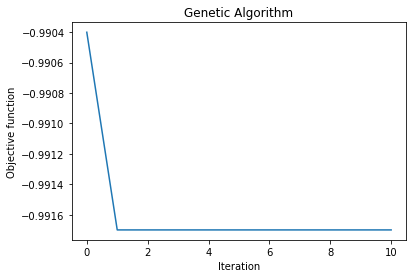

In [25]:
verbose = True
obj_func = run_train_model

lb = [0, params['batch_size'][0]]
ub = [4, params['batch_size'][1]]

algorithm_param = {'max_num_iteration': 10,\
                   'population_size':15,\
                   'mutation_probability':0.2,\
                   'elit_ratio': 0.1,\
                   'crossover_probability': 0.7,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

problem_size = len(ub)

pc = 0.95
pm = 1 - pc

varbound = np.array([ [ lb[0], ub[0] ], [ lb[1], ub[1] ] ] )

model=ga(function=run_train_model,dimension=2,variable_type='real',variable_boundaries=varbound, algorithm_parameters=algorithm_param, random_seed=seed, function_timeout=1000)
model.run(f"{optim_dir}/ga_data-{timestr}.data")

# m.save_output(filename)

In [26]:
hjh

NameError: ignored

In [ ]:
# Function to evaluate the model on the test set
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 1))
        # round to class values
        yhat = yhat.round()
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    return acc

In [ ]:
dfdfd

In [ ]:
# Determine model accuracy on the test set
test_dl = DataLoader(data['test'], batch_size=params['batch_size'], shuffle=False, num_workers=1)
test_acc = evaluate_model(test_dl, model)

In [ ]:

kjkjk

function ClickConnect(){
console.log("Working"); 
 var selector = "#cell-11a2b616"
document.querySelector(selector).click();
  document.querySelector(selector).value = 123;
}
setInterval(ClickConnect,60000)

In [ ]:
dfdf

function ClickConnect(){
console.log("Working"); 
document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click();
}
var clicker = setInterval(ClickConnect,60000);

clearInterval(clicker);